In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import normalize
import seaborn as sns

In [2]:
df = pd.read_csv(".\multiTimeline.csv", sep=",", skiprows=1, header=0)
cols = df.columns
df["slno"] = df.index
df["date"] = pd.to_datetime(df[cols[0]], format="%Y-%m-%d")
df["year"] = df[cols[0]].str.split("-").str[0]
df["month"] = df[cols[0]].str.split("-").str[1]
df["day"] = df[cols[0]].str.split("-").str[2]
df["item"] = cols[1].split(" ")[0][:-1]
df["region"] = cols[1].split(" ")[1][1:-1]
df["volume"] = df[cols[1]]
df.drop(cols, axis=1, inplace=True)
df.head()

,slno,date,year,month,day,item,region,volume
0,0,2021-02-14,2021,02,14,Oxygen,India,2
1,1,2021-02-15,2021,02,15,Oxygen,India,0
2,2,2021-02-16,2021,02,16,Oxygen,India,2
3,3,2021-02-17,2021,02,17,Oxygen,India,4
4,4,2021-02-18,2021,02,18,Oxygen,India,6


In [3]:
df.shape

(87, 8)

#### Laplace

In [4]:
start = 0
end = 87
ls = 1

t = np.arange(start, end, ls)
df_laplcae = df.merge(pd.DataFrame({"slno":t})
                      , on="slno"
                      , how="outer") \
    .sort_values("slno") \
    .reset_index() \
    .loc[:,["slno","volume"]] \
    .fillna(0)
funtion_of_time = df_laplcae.volume.values

no_of_sample = len(t)

u = np.ones(no_of_sample)
u[np.arange(start, end, ls)<0] = 0

sample_freq = fftfreq(no_of_sample, d=ls)
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]

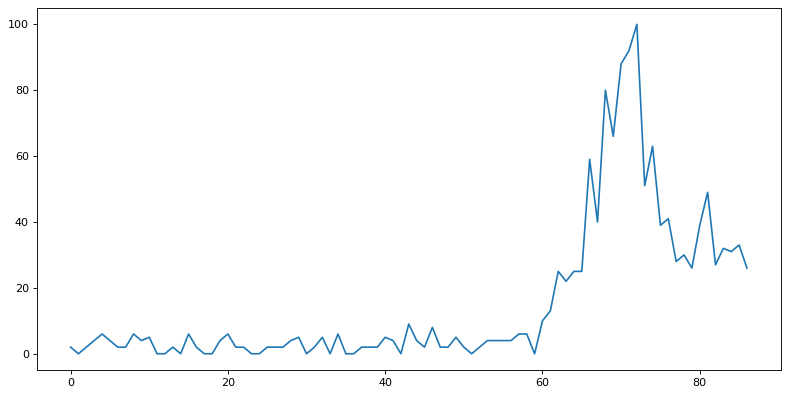

In [5]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(t, funtion_of_time);

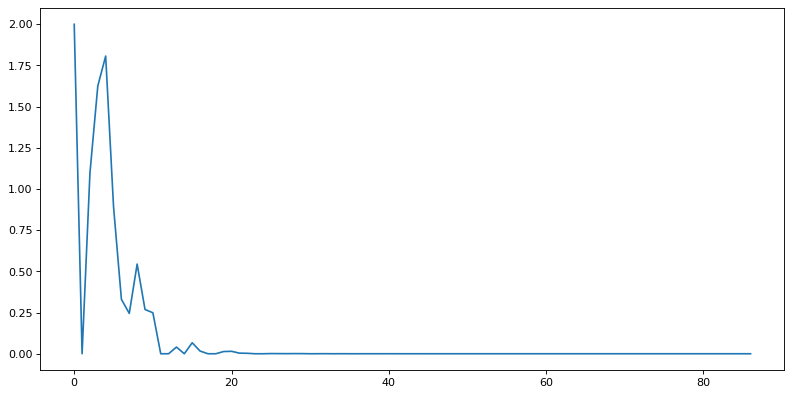

In [6]:
alpha=0.3
funtion_of_time_laplace = u * np.exp(-1*alpha*t)*funtion_of_time
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(t,funtion_of_time_laplace)
plt.show();

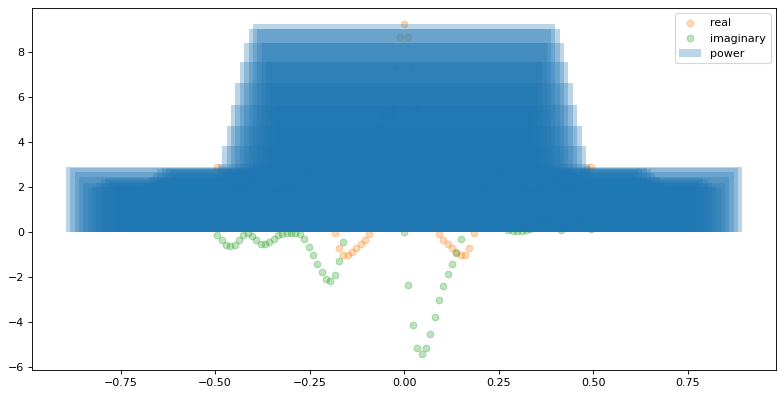

In [7]:
funtion_of_s = fft(funtion_of_time_laplace)
power = np.abs(funtion_of_s)
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(sample_freq, power, alpha=0.3, label="power")
plt.scatter(sample_freq, funtion_of_s.real, alpha=0.3, label="real")
plt.scatter(sample_freq, funtion_of_s.imag, alpha=0.3, label="imaginary")
plt.legend()
plt.show();

In [8]:
peak_freq = freqs[power[pos_mask].argmax()]
peak_power = power[power[pos_mask].argmax()]

In [9]:
alphas = np.arange(-5, 5, 0.25)
for i in range(len(alphas)):
    alpha=alphas[i]
    lap = u * np.exp(-1*alpha*t) * funtion_of_time
    fft_lap = fft(lap)
    if i == 0:
        lt = fft_lap.reshape(1,-1)
    else:
        lt = np.append(lt, fft_lap.reshape(1,-1), axis=0)

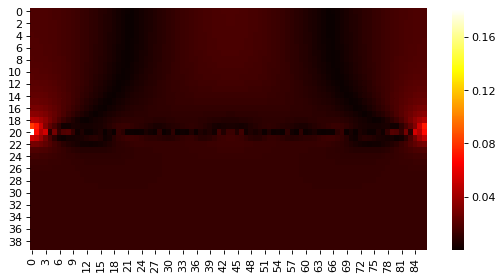

In [10]:
data = np.abs(np.real(lt))
normed_data = normalize(data, axis=1, norm='l1')
plt.figure(figsize=(8, 4), dpi=80)
sns.heatmap(normed_data, cmap='hot')

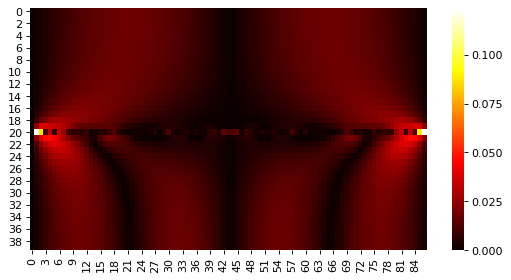

In [11]:
data = np.abs(np.imag(lt))
normed_data = normalize(data, axis=1, norm='l1')
plt.figure(figsize=(8, 4), dpi=80)
sns.heatmap(normed_data, cmap='hot')

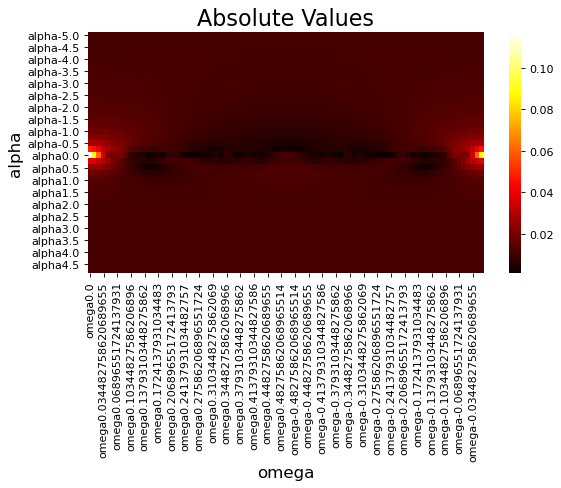

In [12]:
data = np.abs(lt)
normed_data = normalize(data, axis=1, norm='l1')
data = pd.DataFrame(normed_data, columns=["omega"+str(i) for i in sample_freq], index=["alpha"+str(i) for i in alphas])
plt.figure(figsize=(8, 4), dpi=80)
sns.heatmap(data, cmap='hot')
plt.title('Absolute Values', fontsize = 20)
plt.xlabel('omega', fontsize = 15)
plt.ylabel('alpha', fontsize = 15)
plt.show();

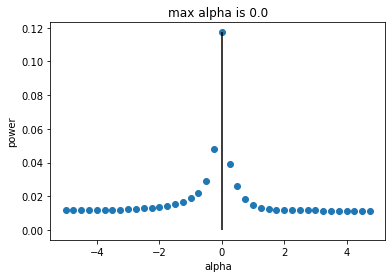

In [13]:
maxpower_wrt_alpha = data.values.argmax(axis=1)
maxpower_wrt_alpha = [data.values[i,maxpower_wrt_alpha[i]] for i in range(len(alphas))]
plt.scatter(alphas, maxpower_wrt_alpha)
plt.vlines(x=alphas[np.array(maxpower_wrt_alpha).argmax()],
           ymin=0,
           ymax=maxpower_wrt_alpha[np.array(maxpower_wrt_alpha).argmax()])
plt.ylabel("power")
plt.xlabel("alpha")
plt.title("max alpha is {}".format(alphas[np.array(maxpower_wrt_alpha).argmax()]))
plt.show();

In [14]:
np.array(maxpower_wrt_alpha).argmax()

20

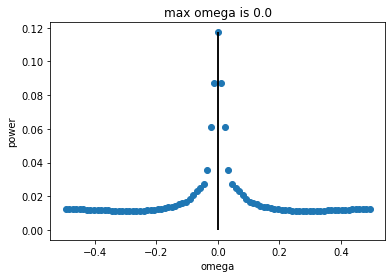

In [15]:
maxpower_wrt_omega = data.values.argmax(axis=0)
maxpower_wrt_omega = [data.values[maxpower_wrt_omega[i],i] for i in range(len(sample_freq))]
plt.scatter(sample_freq, maxpower_wrt_omega)
plt.vlines(x=sample_freq[np.array(maxpower_wrt_omega).argmax()],
           ymin=0,
           ymax=maxpower_wrt_omega[np.array(maxpower_wrt_omega).argmax()])
plt.vlines(x=-1*sample_freq[np.array(maxpower_wrt_omega).argmax()],
           ymin=0,
           ymax=maxpower_wrt_omega[np.array(maxpower_wrt_omega).argmax()])
plt.ylabel("power")
plt.xlabel("omega")
plt.title("max omega is {}".format(sample_freq[np.array(maxpower_wrt_omega).argmax()]))
plt.show();

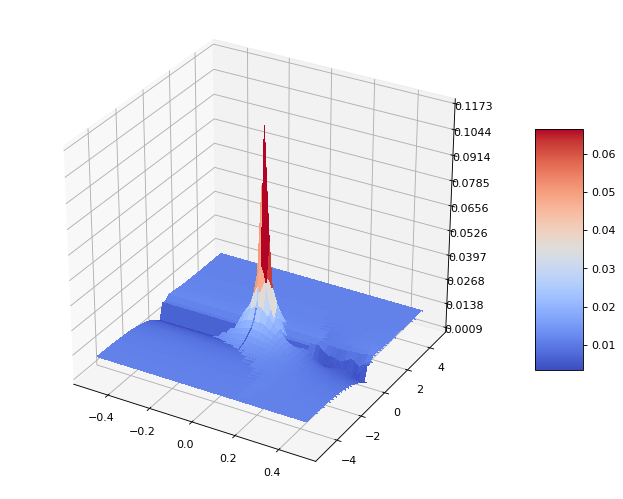

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(10, 8), dpi=80)
ax = fig.gca(projection='3d')

# Make data.
X = sample_freq
Y = alphas
X, Y = np.meshgrid(X, Y)

Z = data.values

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()